In [118]:
%matplotlib inline
from sklearn import neighbors
from nltk.stem.wordnet import WordNetLemmatizer
import string
import seaborn as sns 
from sklearn.metrics import accuracy_score
from sklearn import ensemble
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn import decomposition
import scipy
import sklearn
import spacy
from sklearn.model_selection import train_test_split
import re
import os
import gensim
from gensim.models import word2vec
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from nltk.corpus import gutenberg, stopwords
from collections import Counter

## Goals
Our goal is to be able to confidently organize unlabeled news articles. This model will be important to help news organizations with archives that are so voluminous it would not be practical for employees to organize them by hand.

## Process
We are training our model with BBC news articles due to two factors. One, is that BBC is a highly respected news outlet with large amounts of content. And, two, this corpus comes with labels that can help us to analyze our unsupervised output as well as allow us to train a supervised model. Below you will find our order of operations and I will walk you through our procedures as they occur in the notebook.

## Order of operations

1. Import corpus of documents and document labels
- Tokenize all words, remove punctuation and convert words to their lemmas
- We will begin modeling by using two different methods of feature generation: TFIDF and CBOW word2vec
- We will test our clusters for density and well as cluster separation
- We will look at ground truth for the articles in each cluster to achieve two things
  - Utilizing the information to make an educated decision on which type of article that our         cluster is identifying 
  - Testing our certainty level by investigating how frequently our cluster selects the most         frequent ground truth label
- We will then perform supervised learning with KNN to see how well the unsupervised results compare
- We will display our findings by comparing the clusters with a scatterplot

 Here we are importing our documents and ground truth labels

In [119]:
df_tfidf_train = pd.DataFrame()
df_w2v_train = pd.DataFrame()
df_tfidf_test = pd.DataFrame()
df_w2v_test = pd.DataFrame()
article_list = []
ground_truth = []
categories = ['business', 'entertainment', 'politics', 'sport',  'tech']
for i, category in enumerate(categories):
    for root, dirs, files in os.walk(os.path.join("../bbc_text",category)):
        for file in sorted(files):
            ground_truth.append(i)
            try:
                with open(os.path.join(root,file),"r",encoding='utf-8') as f:
                    article_list.append(f.read())
            except:
                with open(os.path.join(root,file),"r",encoding='iso-8859-1') as f:
                    article_list.append(f.read())
#print(article_list[0])           

We are now converting the words to spacy tokens

In [120]:
nlp = spacy.load('en')
articles_tokenized = nlp.pipe(article_list)

We are eliminating grammar, stop words, and punctuation and are converting all words to their lemmas or root words. We are also creating a list of tokenized documents as well as sentences. 

In [121]:
sentences = []
docs = [] 
for doc in articles_tokenized:
    docs.append(doc)
    for sentence in doc.sents:
        sentence = [
            token.lemma_
            for token in sentence
            if not token.is_stop
            and not token.is_punct
        ]
        sentences.append(sentence)

#print('We have {} sentences'.format(len(sentences)))

In [148]:
X_train_sentences, X_test_sentences = train_test_split(sentences, test_size=0.25)

In [149]:
X_train_docs, X_test_docs, y_train_docs, y_test_docs = train_test_split(docs, ground_truth, test_size=0.25)

In [150]:
X_train_articles, X_test_articles, y_train_articles, y_test_articles = train_test_split(article_list, ground_truth, test_size=0.25)

In [151]:
X_train_text = [doc.text for doc in X_train_docs]
X_test_text = [doc.text for doc in X_test_docs]

In [152]:
def generate_labels(df):
    predicted_clusters = {}
    for cluster_number in df.iloc[:, 0].unique():
        df_sub = df[df.iloc[:, 0] == cluster_number]
        counts = df_sub.groupby(df.columns[1]).count()
        #print(counts)
        predicted_label = counts.iloc[:, 0].argmax()
        predicted_clusters[cluster_number] = predicted_label
    return predicted_clusters

In [153]:
def generate_label_names(df):
    pred_label = df['predicted_label']
    labels = []
    for prediction in pred_label:
        if prediction == 0:
            labels.append('business')
        if prediction == 1:
            labels.append('entertainment')
        if prediction == 2:
            labels.append('politics')
        if prediction == 3:
            labels.append('sports')
        if prediction == 4:
            labels.append('tech')
    return labels

## CBOW word2vec
Here we are generating our features with CBOW word2vec. We determined our window and the minimum count for words to be used in the feature set by trial and error.

In [154]:
cbow_model = word2vec.Word2Vec(
    X_train_sentences,     
    min_count=5,   # Minimum word count threshold.
    window=5,      # Number of words around target word to consider.
    sg=0,          # CBOW
    sample=1e-3 ,  
    size=100,      # when referring to vector legnth is that dimensions?
    hs=1           
)

## Inspection
Here we are testing for similarity of words and looking deeper into the proximity of the vectors. We are testing a variety of different words to determine which word is deemed most similar. The results are displayed below the cell. We tested terms that would be similar to each other but would most likely fall into different clusters like "politician" and "musician".
We also tested how similar words are that should be identified as similar such as "study" and "research". Finally we tested whether the model would select the least similar word from a group of four. This test resulted in a subjectively accurate selection four of the five times. 

In [155]:
vocab = cbow_model.wv.vocab.keys()

print('politician')
print(cbow_model.wv.most_similar('politician'))
print('scientist')
print(cbow_model.wv.most_similar('scientist'))
print('artist')
print(cbow_model.wv.most_similar('artist'))
print('musician')
print(cbow_model.wv.most_similar('musician'))
print('study', 'research')
print(cbow_model.wv.similarity('study', 'research'))
print('computer', 'tool')
print(cbow_model.wv.similarity('computer', 'tool'))
print('musician', 'artist')
print(cbow_model.wv.similarity('musician', 'artist'))
print('phone', 'device')
print(cbow_model.wv.similarity('phone', 'device'))
print(cbow_model.doesnt_match("man woman plane dog".split()))
print(cbow_model.doesnt_match("rock human computer dog".split()))
print(cbow_model.doesnt_match("rock human rocket dog".split()))
print(cbow_model.doesnt_match("car human rocket dog".split()))
print(cbow_model.doesnt_match("car human rocket boat".split()))

politician
[('judgement', 0.8877671360969543), ('answer', 0.8844373226165771), ('response', 0.8609521389007568), ('issue', 0.8377029895782471), ('honesty', 0.8365857005119324), ('present', 0.8336411714553833), ('paper', 0.8287353515625), ('yes', 0.8282246589660645), ('properly', 0.825388491153717), ('engage', 0.8247666358947754)]
scientist
[('interfere', 0.8729540705680847), ('intelligent', 0.8705036640167236), ('license', 0.8644545674324036), ('map', 0.8516850471496582), ('technical', 0.8505517244338989), ('script', 0.8486682176589966), ('devil', 0.8407068252563477), ('teach', 0.8402086496353149), ('danger', 0.8362855315208435), ('establish', 0.836179792881012)]
artist
[('r&b', 0.8960158228874207), ('screenplay', 0.8826783895492554), ('accolade', 0.8727399706840515), ('pop', 0.8705317378044128), ('superhero', 0.8698513507843018), ('song', 0.8692681789398193), ('category', 0.8644145131111145), ('animation', 0.8587868213653564), ('soul', 0.841136634349823), ('talent', 0.8359107375144958

## Generate Vector List
In this cell we are creating a vector list so that we can use the vectors as the input for our model. We are converting them into arrays so that they are able to be proceed by the model.

In [156]:
def create_vector_list(array_shape, X):
    vector_list = []
    for article in X:
        article_vector = np.zeros_like(array_shape)
        for word in article:
            word = word.lemma_ 
            if word in cbow_model.wv:
                vector = cbow_model.wv[word]
                article_vector += vector
        norm = normalize(article_vector.reshape(1, -1))
        norm = norm.flatten()
        vector_list_train.append(norm)
    return vector_list

In [157]:
x = cbow_model.wv['human']
print(len(x))
vector_list_train = []
X_train_w2v = vector_list_train
for article in X_train_docs:
    article_vector = np.zeros_like(x)
    for word in article:
        word = word.lemma_ 
        if word in cbow_model.wv:
            vector = cbow_model.wv[word]
            article_vector += vector
    norm = normalize(article_vector.reshape(1, -1))
    norm = norm.flatten()
    vector_list_train.append(norm)
#print(X_train_w2v[0])

100


In [158]:
x = cbow_model.wv['human']
print(len(x))
vector_list_test = []
X_test_w2v = vector_list_test
for article in X_test_docs:
    article_vector = np.zeros_like(x)
    for word in article:
        word = word.lemma_ 
        if word in cbow_model.wv:
            vector = cbow_model.wv[word]
            article_vector += vector
    norm = normalize(article_vector.reshape(1, -1))
    norm = norm.flatten()
    vector_list_test.append(norm)
#print(vector_list_test[0])

100


## KMeans Clustering
We are training our model and are testing which number of clusters is yields the most dense and separated clusters. We are also testing each model for accuracy by analyzing its performance next to the ground truth labels.

In [159]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
w2v_cluster_models = []
df_w2v_analysis = pd.DataFrame()

for num in number_clusters:
    model = KMeans(n_clusters=num).fit(X_train_w2v)
    prediction_w2v = model.predict(X_train_w2v)
    df_w2v_analysis.loc[num,'Silhouette Score'] = metrics.silhouette_score(X_train_w2v, prediction_w2v, metric='euclidean')
    df_w2v_analysis.loc[num,'Calinski Harabaz Index'] = metrics.calinski_harabaz_score(X_train_w2v, prediction_w2v)
    df_w2v_analysis.loc[num,'K-Means Objective'] = model.score(X_train_w2v)
    df_w2v_analysis.loc[num,'Adjusted Rand Score'] = metrics.adjusted_rand_score(y_train_docs, prediction_w2v)
df_w2v_analysis

,Silhouette Score,Calinski Harabaz Index,K-Means Objective,Adjusted Rand Score
2,0.260838,621.148110,-304.833533,0.310971
3,0.263044,573.942266,-247.710496,0.462482
5,0.309542,618.730166,-168.186890,0.798267
8,0.243230,492.677452,-135.980347,0.600557
10,0.238076,442.449432,-123.022350,0.553066
15,0.191929,353.208515,-104.845046,0.398389
20,0.176455,300.139570,-93.823881,0.324291


In [160]:
model_w2v = KMeans(n_clusters=5).fit(X_train_w2v)
prediction_w2v = model_w2v.predict(X_train_w2v)

In [161]:
prediction_w2v_test = model_w2v.predict(X_test_w2v)

In [162]:
df_w2v_train['pred'] = prediction_w2v
df_w2v_train['labels'] = y_train_docs

In [163]:
df_w2v_test['pred'] = prediction_w2v_test
df_w2v_test['labels'] = y_test_docs

## Semi-supervised
We are now attempting semi-supervised learning by finding which ground truth label our clusters most frequently predict and are assigning that ground truth label to the cluster. We are also investigating how often frequently the ground truth label is selected in each cluster. This will allow us to detremine how much confidence we can have in our clustering model and its selection.

In [164]:
label_map = generate_labels(df_w2v_train)
df_w2v_train['predicted_label'] = df_w2v_train.iloc[:, 0].map(lambda x: label_map[x])
df_w2v_train.head()

,pred,labels,predicted_label,label_names
0,3,4,4,entertainment
1,1,3,3,sports
2,2,0,0,politics
3,4,1,1,business
4,1,3,3,sports


In [165]:
label_names = generate_label_names(df_w2v_train)
df_w2v_train['label_names'] = label_names
df_w2v_train.head()

,pred,labels,predicted_label,label_names
0,3,4,4,tech
1,1,3,3,sports
2,2,0,0,business
3,4,1,1,entertainment
4,1,3,3,sports


In [166]:
df_w2v_test['predicted_label'] = df_w2v_test.iloc[:, 0].map(lambda x: label_map[x])
df_w2v_test.head()

,pred,labels,predicted_label,label_names
0,2,0,0,sports
1,4,4,1,sports
2,4,1,1,sports
3,1,3,3,politics
4,1,3,3,business


In [167]:
label_names_test = generate_label_names(df_w2v_test)
df_w2v_test['label_names'] = label_names_test
df_w2v_test.head()

,pred,labels,predicted_label,label_names
0,2,0,0,business
1,4,4,1,entertainment
2,4,1,1,entertainment
3,1,3,3,sports
4,1,3,3,sports


In [168]:
df_w2v_test['predicted_label']
accuracy_score(df_w2v_test['labels'], df_w2v_test['predicted_label'])

0.90843806104129265

In [169]:
(df_w2v_test['labels'] == df_w2v_test['predicted_label']).mean()

0.90843806104129265

## KNN
Here we we are training our supervised KNN model. We are testing multiple counts of identifiers to see which gives us the most accurate results. We will be able to compare our unsupervised model's success to the success of the KNN model. 

In [170]:
num_neighbors = [2, 5, 10, 15, 20, 22, 25, 30, 40]
df_w2v_knn = pd.DataFrame()
for neighbor in num_neighbors:
    knn_w2v = neighbors.KNeighborsClassifier(n_neighbors=neighbor)
    knn_w2v.fit(X_train_w2v, y_train_docs)
    y_pred_knn_w2v = knn_w2v.predict(X_test_w2v)
    df_w2v_knn.loc[neighbor,'KNN Score'] = knn_w2v.score(X_test_w2v, y_test_docs)
df_w2v_knn

,KNN Score
2,0.951526
5,0.965889
10,0.955117
15,0.953321
20,0.955117
22,0.953321
25,0.956912
30,0.951526
40,0.944345


## RFC
Here we we are training our supervised RFC model. We are testing multiple counts of estimators to see which gives us the most accurate results. We will be able to compare our unsupervised model's success to the success of the RFC model.

In [171]:
num_estimators = [2, 5, 10, 15, 17, 18, 20, 40, 80, 100, 150, 200, 300]
df_w2v_rfc = pd.DataFrame()
for estimator in num_estimators:
    rfc_w2v = ensemble.RandomForestClassifier(n_estimators=estimator, max_depth=10)
    rfc_w2v.fit(X_train_w2v, y_train_docs)
    y_pred_rfc_w2v = rfc_w2v.predict(X_test_w2v)
    df_w2v_rfc.loc[estimator,'RFC Score'] = rfc_w2v.score(X_test_w2v, y_test_docs)
df_w2v_rfc

,RFC Score
2,0.883303
5,0.938959
10,0.951526
15,0.960503
17,0.958707
18,0.955117
20,0.951526
40,0.953321
80,0.955117
100,0.958707


## Visualizations
Below is a scatterplot visualization of the clusters we generated followed by a visualization of the ground truth article groups

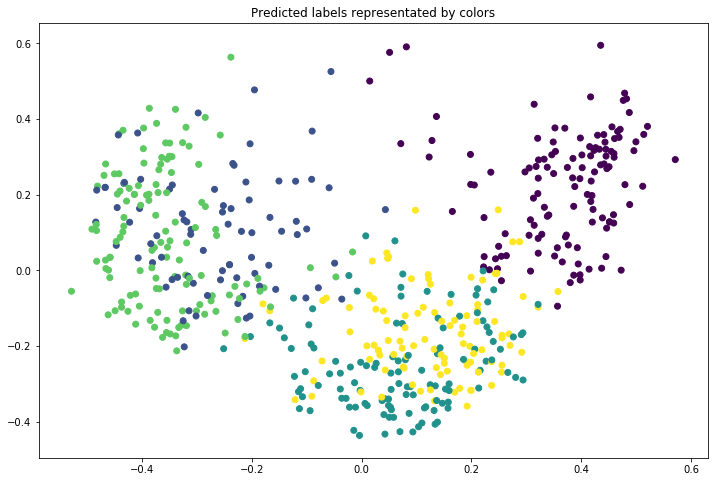

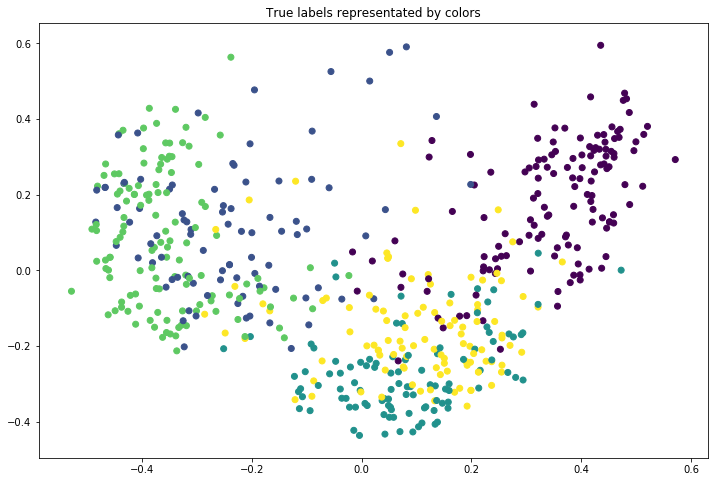

In [172]:
pca = decomposition.PCA(n_components=2)
pca.fit(np.array(X_test_w2v))
X_2 = pca.transform(X_test_w2v)

plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_w2v_test['predicted_label'])
plt.title('Predicted labels representated by colors')
plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_w2v_test['labels'])
plt.title('True labels representated by colors')

Here we are representing our semi-supervised model's selections compared to the ground truth labels with a heatmap.

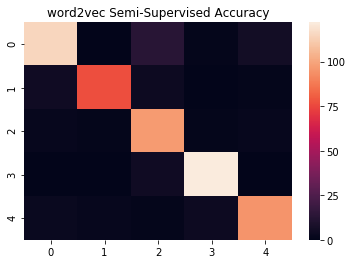

In [173]:
confusion_matrix_w2v = confusion_matrix(df_w2v_test['labels'], df_w2v_test['predicted_label'])
sns.heatmap(confusion_matrix_w2v)
plt.title('word2vec Semi-Supervised Accuracy')

With this confusion matrix we can inspect the accuracy of our semi-supervised model.

In [174]:
print('w2v Confusion Matrix')
print(confusion_matrix_w2v)

w2v Confusion Matrix
[[115   0  13   1   6]
 [  5  77   4   0   1]
 [  2   1  97   1   2]
 [  0   0   5 122   0]
 [  3   2   1   4  95]]


## TFIDF
We will now run the same procedures with tfidf to see if we can outperform the word2vec. All procedures are the same except for the tfidf feature generation. For our parameters we normalized the paragraphs so that longer paragraphs don't carry more weight then our shorter, we  set word frequency to 2 to assure that obscure terms don't skew the model, and we dropped words that occur in more then a quarter of the articles.

In [175]:
vectorizer = TfidfVectorizer(max_df=0.25,          # drop words that occur in more than a quarter of the articles
                             min_df=2,             # only use words that appear at least twice
                             stop_words='english', # picking list of stop words
                             lowercase=True,       # convert everything to lower case
                             max_features=3000,
                             use_idf=True,         # use inverse document frequencies in our weighting
                             norm=u'l2',           # Treat longer and shorter paragraphs equally
                             smooth_idf=True       # Prevent divide-by-zero errors
                            )
# Applying the vectorizer
article_list_tfidf_train = vectorizer.fit_transform(X_train_text)
article_list_tfidf_test = vectorizer.transform(X_test_text)
article_list_tfidf_csr = article_list_tfidf_train.tocsr()
n = article_list_tfidf_csr.shape[0]
tfidf_bypara = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()

In [176]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
X_train_tfidf = article_list_tfidf_train
X_test_tfidf = article_list_tfidf_test
df_tfidf_analysis = pd.DataFrame()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()
for num in number_clusters:
    model_tfidf = KMeans(n_clusters=num).fit(X_train_tfidf)
    prediction_tfidf = model_tfidf.predict(X_train_tfidf)
    model_tfidf_dense = KMeans(n_clusters=num).fit(X_train_tfidf_dense)
    prediction_tfidf_dense = model_tfidf.predict(X_train_tfidf_dense)
    df_tfidf_analysis.loc[num,'Silhouette Score'] = metrics.silhouette_score(X_train_tfidf, prediction_tfidf, metric='euclidean')
    df_tfidf_analysis.loc[num,'Calinski Harabaz Index'] = metrics.calinski_harabaz_score(X_train_tfidf_dense, prediction_tfidf_dense)
    df_tfidf_analysis.loc[num,'K-Means Objective'] = model_tfidf.score(X_train_tfidf_dense)
    df_tfidf_analysis.loc[num,'Adjusted Rand Score'] = metrics.adjusted_rand_score(y_train_docs, prediction_tfidf)
df_tfidf_analysis

,Silhouette Score,Calinski Harabaz Index,K-Means Objective,Adjusted Rand Score
2,0.011177,19.202049,-1598.802722,0.314038
3,0.012962,17.926973,-1583.139105,0.407406
5,0.018739,16.399393,-1555.858907,0.729940
8,0.020565,13.581197,-1529.628290,0.514900
10,0.021689,12.329343,-1515.784181,0.500655
15,0.019708,10.303422,-1487.430658,0.429962
20,0.026493,9.329892,-1460.166702,0.296552


In [177]:
model_tfidf = KMeans(n_clusters=5).fit(X_train_tfidf)
prediction_tfidf = model_tfidf.predict(X_train_tfidf)

In [178]:
prediction_tfidf_test = model_tfidf.predict(X_test_tfidf)

In [179]:
df_tfidf_train['pred'] = prediction_tfidf
df_tfidf_train['labels'] = y_train_docs

In [180]:
df_tfidf_test['pred'] = prediction_tfidf_test
df_tfidf_test['labels'] = y_test_docs

In [191]:
label_map = generate_labels(df_tfidf_train)
df_tfidf_train['predicted_label'] = df_tfidf_train.iloc[:, 0].map(lambda x: label_map[x])
df_tfidf_train.head()

,pred,labels,predicted_label,label_names
0,4,4,4,tech
1,0,3,3,sports
2,2,0,0,business
3,3,1,1,entertainment
4,0,3,3,sports


In [182]:
label_names = generate_label_names(df_tfidf_train)
df_tfidf_train['label_names'] = label_names
df_tfidf_train.head()

,pred,labels,predicted_label,label_names
0,4,4,4,tech
1,0,3,3,sports
2,2,0,0,business
3,3,1,1,entertainment
4,0,3,3,sports


In [183]:
label_map = generate_labels(df_tfidf_test)
df_tfidf_test['predicted_label'] = df_tfidf_test.iloc[:, 0].map(lambda x: label_map[x])
df_tfidf_test.head()

,pred,labels,predicted_label
0,2,0,0
1,4,4,4
2,3,1,1
3,0,3,3
4,0,3,3


In [184]:
label_names = generate_label_names(df_tfidf_test)
df_tfidf_test['label_names'] = label_names
df_tfidf_test.head()

,pred,labels,predicted_label,label_names
0,2,0,0,business
1,4,4,4,tech
2,3,1,1,entertainment
3,0,3,3,sports
4,0,3,3,sports


In [185]:
df_tfidf_test['predicted_label']
accuracy_score(df_tfidf_test['labels'], df_tfidf_test['predicted_label'])

0.93357271095152605

In [186]:
num_neighbors = [2, 5, 10, 15, 20, 40, 43, 50, 60, 80]
df_tfidf_knn = pd.DataFrame()
for neighbor in num_neighbors:
    knn_tfidf = neighbors.KNeighborsClassifier(n_neighbors=neighbor)
    knn_tfidf.fit(X_train_tfidf, y_train_docs)
    y_pred_knn_tfidf = knn_tfidf.predict(X_test_tfidf)
    df_tfidf_knn.loc[neighbor,'KNN Score'] = knn_tfidf.score(X_test_tfidf, y_test_docs)
df_tfidf_knn

,KNN Score
2,0.919210
5,0.942549
10,0.951526
15,0.955117
20,0.962298
40,0.955117
43,0.953321
50,0.947935
60,0.949731
80,0.949731


In [187]:
num_estimators = [2, 5, 10, 15, 17, 18, 20, 40, 80, 90, 100, 110, 120, 130, 140, 150, 200, 300]
df_tfidf_rfc = pd.DataFrame()
for estimator in num_estimators:
    rfc_tfidf = ensemble.RandomForestClassifier(n_estimators=estimator, max_depth=10)
    rfc_tfidf.fit(X_train_tfidf, y_train_docs)
    y_pred_rfc_tfidf = rfc_tfidf.predict(X_test_tfidf)
    df_tfidf_rfc.loc[estimator,'RFC Score'] = rfc_tfidf.score(X_test_tfidf, y_test_docs)
df_tfidf_rfc

,RFC Score
2,0.685817
5,0.820467
10,0.885099
15,0.863555
17,0.904847
18,0.921005
20,0.908438
40,0.933573
80,0.946140
90,0.937163


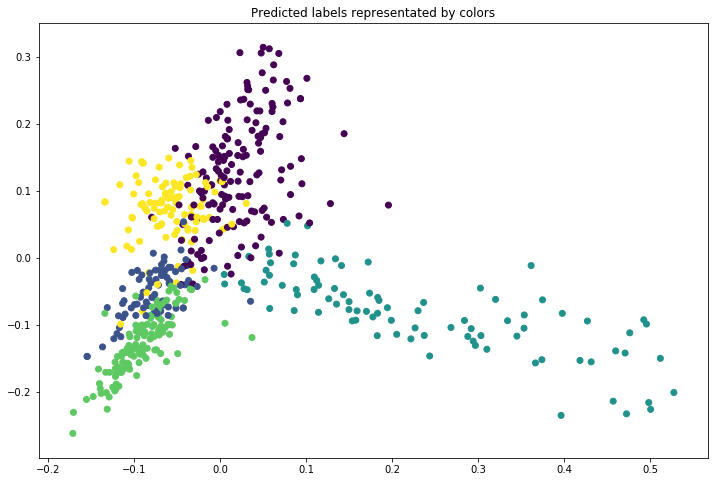

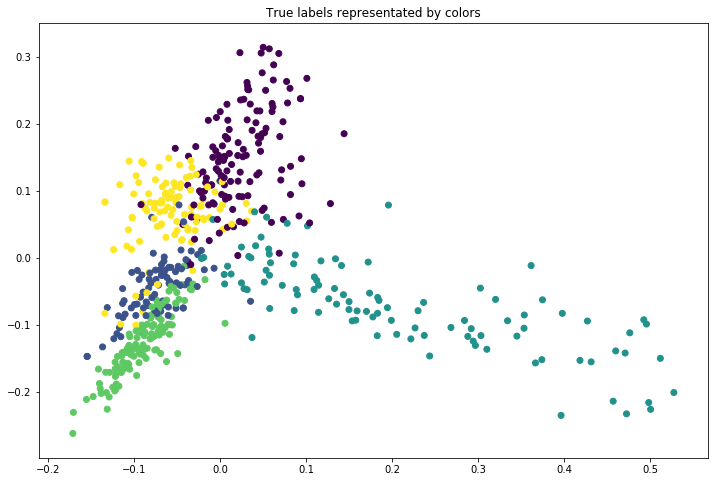

In [188]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_test_tfidf_dense)
X_2 = pca.transform(X_test_tfidf_dense)

plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_tfidf_test['predicted_label'])
plt.title('Predicted labels representated by colors')
plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_tfidf_test['labels'])
plt.title('True labels representated by colors')

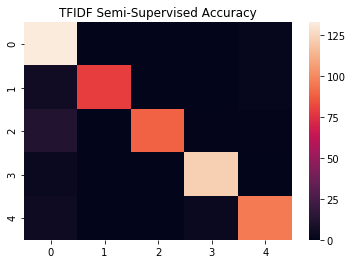

In [189]:
confusion_matrix_tfidf = confusion_matrix(df_tfidf_test['labels'], df_tfidf_test['predicted_label'])
sns.heatmap(confusion_matrix_tfidf)
plt.title('TFIDF Semi-Supervised Accuracy')

In [190]:
print('TFIDF Confusion Matrix')
print(confusion_matrix_tfidf)

TFIDF Confusion Matrix
[[133   0   0   0   2]
 [  6  79   0   0   2]
 [ 12   0  89   1   1]
 [  4   0   0 123   0]
 [  5   0   0   4  96]]


## Conclusion:

After running unsupervised clustering, semi-supervised classification from those results, and running K-Nearest Neighbor and Random Forrest Classification we have a strong conclusion:
- Based on the Silhouette scores and Calinski Harabaz Index we can find a good performance balance and determine that the most successful clusters are generated when we specify that we want five clusters. This makes sense as there are five ground truth labels.
- When we classified our documents using a semi-supervised method we determined the labels based on the most frequent label in each of the clusters produced by K-Means.
- Semi-supervised word2vec underperforms tfidf due to how frequently it correctly identifies the ground truth labels. The scores are .9084 to .9336 respectively. 
- When we compare the strongest performing supervised learning categories for word2vec we get .9659 for RFC compared to .9084 semi-supervised exhibiting a .0575 difference. 
- When we compare the strongest performing supervised learning categories for tfidf we get .9623 for KNN compared to .9336 semi-supervised exhibiting a .0287 difference. 

We can now determine that our method of semi-supervised clustering is successful 93.4% of the time and we can use this model to cluster unlabeled documents of similar nature to our training and test sets. The percentage of improvement for the best performing supervised learning model when working with tfidf only increased the success rate by .0287 so we can conclude that classifying documents without labels should be nearly as successful as classifying them without a ground truth.
